# Solving a Dynamic Programming Problem

In [90]:
import numpy as np
# import scipy 
from scipy.optimize import brentq    #equation solver
from scipy import optimize
from scipy.stats import norm
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import numpy.polynomial.chebyshev as chebyshev
import numba
from scipy import interpolate

## Value Function Iteration

In [91]:
alpha  = 0.33
beta   = 0.98
delta  = 0.13
A      = 2

@numba.njit
def f(k):
    return A*k**alpha + (1-delta)*k
@numba.njit
def fk(k):
    return A*alpha*k**(alpha-1) + (1-delta)

@numba.njit
def util(c):
    return np.log(c)

In [92]:
kstar = ((1/beta - 1 + delta)/A/alpha)**(1/(alpha-1))
kstar

9.091084887868014

In [93]:
assert np.isclose(beta*fk(kstar), 1)

In [94]:
# polynomial approximation of Value function
N = 6
# grid
k = np.linspace(0.01, 15, 300)

In [95]:
# Compute value function today
@numba.njit
def Vendog(kplus, k, Vplus):
        value = util(f(k) - kplus) + beta * Vplus
        return  value

# Backward iteration
@numba.njit
def backward_iterate(maxindex, V, k):
    for ik, k_cur in enumerate(k):
#         print("number on capital grid", ik)
        value = np.empty_like(k)
        
        for ik2, k_cur2 in enumerate(k):
            value[ik2] = Vendog(k[ik2], k_cur, V[ik2])
#         print(value)
        index         = np.argmax(value)
        maxindex[ik]  = index
        V[ik]     = value[index]
#         print("Value", V[ik])
    return maxindex, V

In [96]:
# Iteration algorithm
def ss_policy(k):
    maxindex = np.zeros_like(k)
    V    = np.zeros_like(k, dtype=float)
    for it in range(2000):
        maxindex, V = backward_iterate(maxindex, V, k)   
        if it % 10 == 1 and  np.linalg.norm(V - Vold) < 1E-20:
            print(f'convergence in {it} iterations!')
            return maxindex.astype(int), V
        #Fit value function for interpolation
        Vold = np.copy(V)
        
        

In [97]:
%time maxindex, V = ss_policy(k)

convergence in 1311 iterations!
CPU times: user 1.81 s, sys: 0 ns, total: 1.81 s
Wall time: 1.83 s


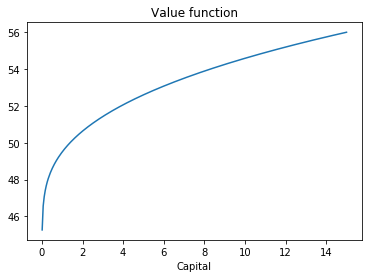

In [98]:
plt.plot(k, V)
plt.xlabel("Capital")
plt.title('Value function');

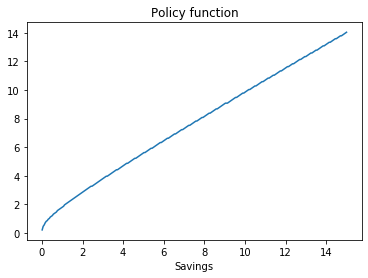

In [99]:
plt.plot(k, k[maxindex.astype(int)])
plt.xlabel("Capital")
plt.xlabel("Savings")
plt.title('Policy function');

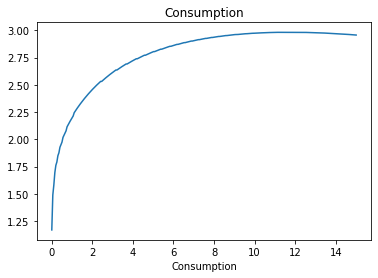

In [101]:
c = f(k[maxindex.astype(int)]) - k[maxindex.astype(int)]
plt.plot(k, c)
plt.xlabel("Capital")
plt.xlabel("Consumption")
plt.title('Consumption');

In [201]:
## Steady state level of capital
kstar = k[k[maxindex] == k]
kstar

array([9.08421405])

In [207]:
@numba.njit
def policy_interp(x, k, maxindex):
    policy = np.interp(x, k, k[maxindex])
    return policy

@numba.njit
def timeseries(start, periods, k, maxindex):
    series = np.empty(periods)
    series[0] = start
    for t in range(periods-1):
        series[t+1]  = policy_interp(series[t], k, maxindex)
    return series


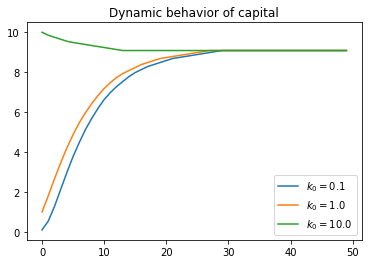

In [214]:
start = np.array([0.1, 1, 10])
T = 50

for element in start:
    series = timeseries(element, T, k, maxindex)
    plt.plot(range(T), 
    series, label=r'$k_0 = {j} $'.format(j=element))
plt.legend()
plt.title('Dynamic behavior of capital');

This model predicts rapid convergence of capital towards the steady state over the medium run. 

### Howard policy improvement

In [115]:
k = np.linspace(0.1, 15, 30)
# Howard Value iteration for given policy
# @numba.njit
def howard_ss_value(kplus, k, V_h):
    V_update = np.empty_like(V_h)
    for it in range(2000):
        V_update = util(f(k) - kplus) + beta * V_h
        if it % 10 == 1 and  np.linalg.norm(V_update - V_h) < 1E-5:
            print(f'Howard convergence in {it} iterations!')
            return V_update
        #Fit value function for interpolation
        V_h = np.copy(V_update)

# Backward iteration

# Backward iteration
def backward_iterate_howard(maxindex, Vold, k):
    V = np.empty_like(Vold)
    for ik, k_cur in enumerate(k):
#         print("number on capital grid", ik)
        value = np.empty_like(k)
        
        for ik2, k_cur2 in enumerate(k):
            value[ik2] = Vendog(k[ik2], k_cur, Vold[ik2])
        index         = np.nanargmax(value)
        maxindex[ik]  = np.copy(index)
        V[ik]     = value[index]
#     print(V)
    for ik, k_cur in enumerate(k):
        index     = maxindex[ik].astype(int)
        V[ik]     = howard_ss_value(k[index], k_cur, V[ik])
#         print("Value", V[ik])
#     print(V)
    return maxindex, V

In [116]:
# Iteration algorithm
def ss_policy_howard(k):
    maxindex = np.zeros_like(k)
    Vold    = np.zeros_like(k)
    for it in range(2000):
        maxindex, V = backward_iterate_howard(maxindex, Vold, k)
        if it % 10 == 1 and  np.linalg.norm(V - Vold) < 1E-10:
            print(f'convergence in {it} iterations!')
            return maxindex.astype(int), V
        #Fit value function for interpolation
        print(np.linalg.norm(V - Vold))
        Vold = np.copy(V)
        

In [117]:
%time maxindex_howard, V_howard = ss_policy_howard(k)

Howard convergence in 451 iterations!
Howard convergence in 561 iterations!
Howard convergence in 581 iterations!
Howard convergence in 591 iterations!
Howard convergence in 591 iterations!
Howard convergence in 601 iterations!
Howard convergence in 601 iterations!
Howard convergence in 601 iterations!
Howard convergence in 601 iterations!
Howard convergence in 611 iterations!
Howard convergence in 611 iterations!
Howard convergence in 611 iterations!
Howard convergence in 611 iterations!
Howard convergence in 611 iterations!
Howard convergence in 611 iterations!
Howard convergence in 621 iterations!
Howard convergence in 621 iterations!
Howard convergence in 621 iterations!
Howard convergence in 621 iterations!
Howard convergence in 621 iterations!
Howard convergence in 621 iterations!
Howard convergence in 621 iterations!
Howard convergence in 621 iterations!
Howard convergence in 621 iterations!
Howard convergence in 621 iterations!
Howard convergence in 621 iterations!
Howard conve

Howard convergence in 581 iterations!
Howard convergence in 581 iterations!
Howard convergence in 581 iterations!
Howard convergence in 591 iterations!
Howard convergence in 591 iterations!
Howard convergence in 591 iterations!
Howard convergence in 591 iterations!
Howard convergence in 591 iterations!
Howard convergence in 591 iterations!
Howard convergence in 591 iterations!
Howard convergence in 601 iterations!
Howard convergence in 601 iterations!
Howard convergence in 601 iterations!
Howard convergence in 601 iterations!
Howard convergence in 601 iterations!
Howard convergence in 601 iterations!
820.4950379629671
Howard convergence in 571 iterations!
Howard convergence in 641 iterations!
Howard convergence in 611 iterations!
Howard convergence in 641 iterations!
Howard convergence in 631 iterations!
Howard convergence in 621 iterations!
Howard convergence in 621 iterations!
Howard convergence in 661 iterations!
Howard convergence in 651 iterations!
Howard convergence in 641 iterat

Howard convergence in 651 iterations!
Howard convergence in 641 iterations!
Howard convergence in 641 iterations!
Howard convergence in 641 iterations!
Howard convergence in 641 iterations!
Howard convergence in 641 iterations!
Howard convergence in 641 iterations!
Howard convergence in 641 iterations!
Howard convergence in 641 iterations!
Howard convergence in 641 iterations!
Howard convergence in 641 iterations!
Howard convergence in 641 iterations!
Howard convergence in 641 iterations!
Howard convergence in 641 iterations!
Howard convergence in 641 iterations!
Howard convergence in 641 iterations!
Howard convergence in 641 iterations!
Howard convergence in 631 iterations!
Howard convergence in 621 iterations!
Howard convergence in 611 iterations!
Howard convergence in 611 iterations!
Howard convergence in 601 iterations!
855.604967319266
Howard convergence in 561 iterations!
Howard convergence in 601 iterations!
Howard convergence in 611 iterations!
Howard convergence in 511 iterati

Howard convergence in 581 iterations!
Howard convergence in 591 iterations!
Howard convergence in 601 iterations!
Howard convergence in 611 iterations!
Howard convergence in 581 iterations!
Howard convergence in 561 iterations!
Howard convergence in 531 iterations!
Howard convergence in 491 iterations!
Howard convergence in 1 iterations!
649.9578810255422
Howard convergence in 601 iterations!
Howard convergence in 571 iterations!
Howard convergence in 531 iterations!
Howard convergence in 461 iterations!
Howard convergence in 621 iterations!
Howard convergence in 621 iterations!
Howard convergence in 621 iterations!
Howard convergence in 661 iterations!
Howard convergence in 641 iterations!
Howard convergence in 641 iterations!
Howard convergence in 641 iterations!
Howard convergence in 631 iterations!
Howard convergence in 631 iterations!
Howard convergence in 631 iterations!
Howard convergence in 631 iterations!
Howard convergence in 621 iterations!
Howard convergence in 611 iteratio

Howard convergence in 431 iterations!
Howard convergence in 511 iterations!
Howard convergence in 531 iterations!
Howard convergence in 541 iterations!
Howard convergence in 551 iterations!
Howard convergence in 561 iterations!
Howard convergence in 571 iterations!
Howard convergence in 571 iterations!
Howard convergence in 571 iterations!
Howard convergence in 581 iterations!
Howard convergence in 611 iterations!
Howard convergence in 611 iterations!
Howard convergence in 621 iterations!
Howard convergence in 621 iterations!
Howard convergence in 621 iterations!
Howard convergence in 621 iterations!
Howard convergence in 621 iterations!
Howard convergence in 621 iterations!
Howard convergence in 621 iterations!
Howard convergence in 631 iterations!
Howard convergence in 631 iterations!
Howard convergence in 611 iterations!
Howard convergence in 601 iterations!
Howard convergence in 591 iterations!
Howard convergence in 581 iterations!
Howard convergence in 571 iterations!
644.28903650

Howard convergence in 651 iterations!
Howard convergence in 621 iterations!
Howard convergence in 601 iterations!
Howard convergence in 591 iterations!
Howard convergence in 581 iterations!
Howard convergence in 571 iterations!
Howard convergence in 561 iterations!
Howard convergence in 561 iterations!
Howard convergence in 551 iterations!
Howard convergence in 541 iterations!
Howard convergence in 521 iterations!
Howard convergence in 511 iterations!
Howard convergence in 491 iterations!
Howard convergence in 471 iterations!
Howard convergence in 431 iterations!
Howard convergence in 361 iterations!
Howard convergence in 441 iterations!
Howard convergence in 471 iterations!
Howard convergence in 491 iterations!
Howard convergence in 501 iterations!
Howard convergence in 511 iterations!
Howard convergence in 521 iterations!
672.7163952721089
Howard convergence in 561 iterations!
Howard convergence in 601 iterations!
Howard convergence in 611 iterations!
Howard convergence in 511 iterat

Howard convergence in 631 iterations!
Howard convergence in 631 iterations!
Howard convergence in 631 iterations!
Howard convergence in 631 iterations!
Howard convergence in 631 iterations!
Howard convergence in 631 iterations!
Howard convergence in 631 iterations!
Howard convergence in 631 iterations!
Howard convergence in 631 iterations!
Howard convergence in 631 iterations!
Howard convergence in 631 iterations!
Howard convergence in 631 iterations!
Howard convergence in 631 iterations!
Howard convergence in 631 iterations!
Howard convergence in 631 iterations!
Howard convergence in 631 iterations!
Howard convergence in 621 iterations!
Howard convergence in 611 iterations!
Howard convergence in 601 iterations!
Howard convergence in 591 iterations!
Howard convergence in 591 iterations!
584.9862113892024
Howard convergence in 601 iterations!
Howard convergence in 571 iterations!
Howard convergence in 531 iterations!
Howard convergence in 461 iterations!
Howard convergence in 471 iterat

Howard convergence in 551 iterations!
Howard convergence in 561 iterations!
Howard convergence in 561 iterations!
Howard convergence in 571 iterations!
Howard convergence in 571 iterations!
Howard convergence in 581 iterations!
Howard convergence in 581 iterations!
Howard convergence in 581 iterations!
Howard convergence in 581 iterations!
Howard convergence in 591 iterations!
Howard convergence in 591 iterations!
Howard convergence in 591 iterations!
Howard convergence in 591 iterations!
Howard convergence in 591 iterations!
Howard convergence in 591 iterations!
Howard convergence in 591 iterations!
Howard convergence in 601 iterations!
Howard convergence in 601 iterations!
Howard convergence in 601 iterations!
Howard convergence in 601 iterations!
Howard convergence in 601 iterations!
Howard convergence in 601 iterations!
820.4950379629671
Howard convergence in 571 iterations!
Howard convergence in 641 iterations!
Howard convergence in 611 iterations!
Howard convergence in 641 iterat

Howard convergence in 641 iterations!
Howard convergence in 631 iterations!
Howard convergence in 621 iterations!
Howard convergence in 621 iterations!
Howard convergence in 661 iterations!
Howard convergence in 651 iterations!
Howard convergence in 641 iterations!
Howard convergence in 641 iterations!
Howard convergence in 641 iterations!
Howard convergence in 641 iterations!
Howard convergence in 641 iterations!
Howard convergence in 641 iterations!
Howard convergence in 641 iterations!
Howard convergence in 641 iterations!
Howard convergence in 641 iterations!
Howard convergence in 641 iterations!
Howard convergence in 641 iterations!
Howard convergence in 641 iterations!
Howard convergence in 641 iterations!
Howard convergence in 641 iterations!
Howard convergence in 641 iterations!
Howard convergence in 641 iterations!
Howard convergence in 631 iterations!
Howard convergence in 621 iterations!
Howard convergence in 611 iterations!
Howard convergence in 611 iterations!
Howard conve

Howard convergence in 621 iterations!
Howard convergence in 611 iterations!
Howard convergence in 611 iterations!
Howard convergence in 601 iterations!
855.604967319266
Howard convergence in 561 iterations!
Howard convergence in 601 iterations!
Howard convergence in 611 iterations!
Howard convergence in 511 iterations!
Howard convergence in 571 iterations!
Howard convergence in 591 iterations!
Howard convergence in 601 iterations!
Howard convergence in 601 iterations!
Howard convergence in 611 iterations!
Howard convergence in 611 iterations!
Howard convergence in 621 iterations!
Howard convergence in 621 iterations!
Howard convergence in 621 iterations!
Howard convergence in 621 iterations!
Howard convergence in 621 iterations!
Howard convergence in 621 iterations!
Howard convergence in 621 iterations!
Howard convergence in 631 iterations!
Howard convergence in 631 iterations!
Howard convergence in 631 iterations!
Howard convergence in 561 iterations!
Howard convergence in 581 iterati

Howard convergence in 631 iterations!
Howard convergence in 631 iterations!
Howard convergence in 631 iterations!
Howard convergence in 561 iterations!
Howard convergence in 581 iterations!
Howard convergence in 591 iterations!
Howard convergence in 601 iterations!
Howard convergence in 611 iterations!
Howard convergence in 581 iterations!
Howard convergence in 561 iterations!
Howard convergence in 531 iterations!
Howard convergence in 491 iterations!
Howard convergence in 1 iterations!
649.9578810255422
Howard convergence in 601 iterations!
Howard convergence in 571 iterations!
Howard convergence in 531 iterations!
Howard convergence in 461 iterations!
Howard convergence in 621 iterations!
Howard convergence in 621 iterations!
Howard convergence in 621 iterations!
Howard convergence in 661 iterations!
Howard convergence in 641 iterations!
Howard convergence in 641 iterations!
Howard convergence in 641 iterations!
Howard convergence in 631 iterations!
Howard convergence in 631 iteratio

Howard convergence in 631 iterations!
Howard convergence in 621 iterations!
Howard convergence in 611 iterations!
Howard convergence in 601 iterations!
Howard convergence in 591 iterations!
Howard convergence in 581 iterations!
Howard convergence in 571 iterations!
Howard convergence in 571 iterations!
Howard convergence in 561 iterations!
Howard convergence in 551 iterations!
Howard convergence in 541 iterations!
Howard convergence in 541 iterations!
Howard convergence in 531 iterations!
Howard convergence in 521 iterations!
Howard convergence in 501 iterations!
Howard convergence in 491 iterations!
625.5529037384331
Howard convergence in 571 iterations!
Howard convergence in 591 iterations!
Howard convergence in 551 iterations!
Howard convergence in 501 iterations!
Howard convergence in 431 iterations!
Howard convergence in 511 iterations!
Howard convergence in 531 iterations!
Howard convergence in 541 iterations!
Howard convergence in 551 iterations!
Howard convergence in 561 iterat

KeyboardInterrupt: 

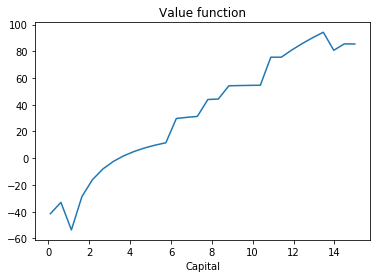

In [118]:
plt.plot(k, V_howard)
plt.xlabel("Capital")
plt.title('Value function');

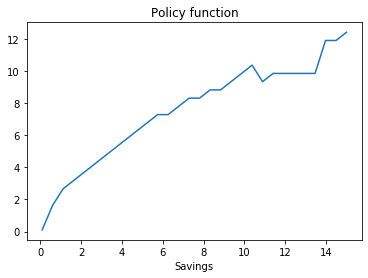

In [119]:
plt.plot(k, k[maxindex_howard.astype(int)])
plt.xlabel("Capital")
plt.xlabel("Savings")
plt.title('Policy function');

## Policy Function Iteration - Method I

### Euler equation

First-order and envelope conditions

$$
\begin{align}
u'(c(k)) &= \beta [V_k(k_+)] \\
V_k(k) &= f_k(k) u'(c(k)) \\
\end{align}
$$

can be combined to obtain a Euler equation

$$
u'(c(k)) = \beta \mathbb{E}[f_k(k_+(k))u'(c(k_+(k)))]
$$

In [17]:
def up(c):
    return 1/c

In [216]:
def chebyshev_interp(x, y):
    X = chebyshev.chebvander(x, len(x)-1)
    return np.linalg.solve(X, y)

In [258]:
def Euler_err(kplus, q, k):
    cendog = chebyshev.chebval(kplus, q)
    print("Best Response to K'", cendog)
    err = up(f(k) - kplus) - beta * fk(kplus) * up(cendog)
#     print(err)
    return err

def backward_iterate_chebyshev(cplus, k, kmin, kmax):

    q = chebyshev_interp(k, cplus)
    print("parameters", q)
    kplus = np.empty(len(k))
    cendog = np.empty(len(k))
    for ik, k_cur in enumerate(k):
        kplus[ik] = brentq(Euler_err, kmin, kmax, args=(q, k_cur))
        cendog[ik] = f(k[ik]) - kplus[ik]
    print('Savings', kplus)
#     print("Updated C", cendog)
    return cendog


In [259]:
def chebyshev_nodes(xlow, xhigh, N):
    standard_nodes = -np.cos((2*np.arange(1, N+1)-1)/(2*N)*np.pi)
    x = xlow + (xhigh-xlow)/2*(1+standard_nodes)
    return x

k = chebyshev_nodes(0.1, 15, 10)

def ss_policy_chebyshev(k, kmin, kmax):
    c = np.empty(len(k))
    cplus = 0.3*k
    for it in range(1000):
        print("Iteration number:", it)
#         print("Old C", cplus)
        c = backward_iterate_chebyshev(cplus, k, kmin, kmax) 
        print(np.linalg.norm(cplus - c))
        if it % 10 == 1 and  np.linalg.norm(cplus - c) < 1E-10:
            print(f'convergence in {it} iterations!')
            # need to do an extra interpolation now at the end of consumption against capital gridpoints
            # to get the Chebyshev approx for k -> c map (rather than f(k) -> c)
            # omitting this was my mistake before
            return chebyshev_interp(k, c.T).T
        cplus = np.copy(c)
    

In [260]:
%time q = ss_policy_chebyshev(k, -10*kstar, 20*kstar)

Iteration number: 0
parameters [ 1.00558452e-15  3.00000000e-01  9.28831781e-16 -2.71218815e-16
  4.29679257e-17 -3.93215369e-18  2.14558208e-19 -6.88379977e-21
  1.19660642e-22 -8.68201476e-25]
Best Response to K' -27.273062070035177
Best Response to K' 54.513878759685134
Best Response to K' -27.273062070035177
Best Response to K' 54.513878759685134
Best Response to K' -27.273062070035177
Best Response to K' 54.513878759685134
Best Response to K' -27.273062070035177
Best Response to K' 54.513878759685134
Best Response to K' -27.273062070035177
Best Response to K' 54.513878759685134
Best Response to K' -27.273062070035177
Best Response to K' 54.513878759685134
Best Response to K' -27.273062070035177
Best Response to K' 54.513878759685134
Best Response to K' -27.273062070035177
Best Response to K' 54.513878759685134
Best Response to K' -27.273062070035177
Best Response to K' 54.513878759685134
Best Response to K' -27.273062070035177
Best Response to K' 54.513878759685134
Savings [0. 0. 

No handles with labels found to put in legend.


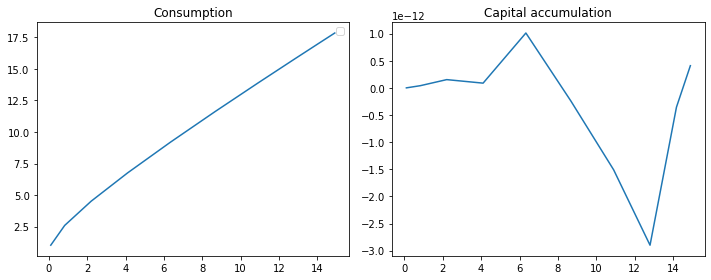

In [233]:
c = chebyshev.chebval(k, c_q.T)
savings = f(k) - c
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.set_title('Consumption')
ax2.set_title('Capital accumulation')
ax1.plot(k, c)
ax2.plot(k, savings)
ax1.legend()
plt.tight_layout()

In [118]:

def Euler_err_cubic(kplus, tck, k):
    err = up(f(k) - kplus) - beta * fk(kplus) * up(interpolate.splev(kplus, tck))
    return err


def backward_iterate_cubic(cplus, k):

    kplus = np.empty(len(k))
    cendog = np.empty(len(k))
    tck = interpolate.splrep(k, cplus)
    fun = lambda x: Euler_err_cubic(x, tck, k_cur)
    for ik, k_cur in enumerate(k):
        res = optimize.root(fun, cplus[ik], method='hybr')
        kplus[ik] = res.x
        cendog[ik] = f(k[ik]) - kplus[ik]
    return cendog


In [119]:
k = np.linspace(0.01, 15, 300)

def ss_policy_cubic(k):
    c = np.empty(len(k))
    cplus = 0.2*k
    for it in range(1000):
#         print("Iteration number:", it)
#         print("Old C", cplus)
        c = backward_iterate_cubic(cplus, k) 
#         print(np.linalg.norm(cplus - c))
        if it % 10 == 1 and  np.linalg.norm(cplus - c) < 1E-10:
            print(f'convergence in {it} iterations!')
            return interpolate.splrep(k, c)
        cplus = np.copy(c)
    

In [122]:
%prun tck = ss_policy_cubic(k)

convergence in 131 iterations!
 

No handles with labels found to put in legend.


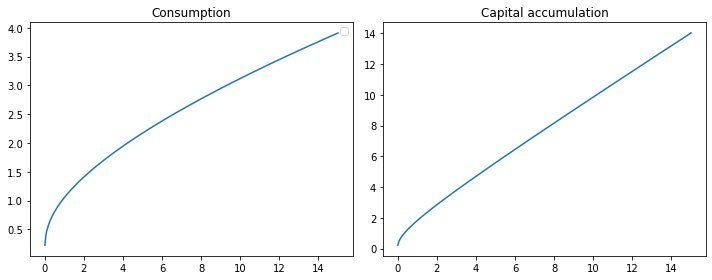

In [123]:
c = interpolate.splev(k, tck)
savings = f(k) - c
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.set_title('Consumption')
ax2.set_title('Capital accumulation')
ax1.plot(k, c)
ax2.plot(k, savings)
ax1.legend()
plt.tight_layout()

In [124]:
#Find a fixed point
fun = lambda x: f(x) - interpolate.splev(x, tck)
kstar = optimize.fixed_point(fun, [7, 10])
kstar

array([9.09108489, 9.09108489])

### Policy Function Iteration - Method II

In [ ]:
def chebyshev_nodes(xlow, xhigh, N):
    standard_nodes = -np.cos((2*np.arange(1, N+1)-1)/(2*N)*np.pi)
    x = xlow + (xhigh-xlow)/2*(1+standard_nodes)
    return x
k = chebyshev_nodes(0.01, 15, 100)

# Iteration algorithm
def ss_policy(k):
    kplus = 0.7*k
    V     = np.zeros_like(k)
    q     = np.zeros_like(k)     # initialize with zeros 
    for it in range(2000):
        kplus, V = backward_iterate(kplus, V, k, q)
        if it % 10 == 1:
            print('Iteration number', it)
            print('Residual is', np.abs(V - Vold))
        
        if it % 10 == 1 and  np.max(np.abs(V - Vold)) < 1E-5:
            print(f'convergence in {it} iterations!')
            return kplus, V
        #Fit value function for interpolation
        q = chebyshev.chebfit(k, V, N)
        Vold = V
        